## Work
1. 請嘗試寫一個 callback 用來記錄各類別在訓練過程中，對驗證集的 True Positive 與 True Negative

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [7]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [8]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 25
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [20]:
from keras.callbacks import Callback
from sklearn.metrics import f1_score, multilabel_confusion_matrix
from keras import backend as K
import numpy as np
# Record_fp_tp
class Record_tp_tn(Callback):
    """Code Here
    撰寫一個紀錄 ture positive 與 true negative 數量的 callbacks    
    """
    def __init__(self, validation_data):
        self.validation_data = validation_data
    def on_train_begin(self, epoch, logs = {}):
        logs = logs or {}
        record_items = ["val_auc", "val_fp", "val_fn", "val_tp", "val_tn"]
        print(logs.keys())
        for i in record_items:            
            if i not in logs.keys():
                logs[i]=[]
        print(logs)        
             
    def on_epoch_end(self, epoch, logs = {}, thres=0.5):
        logs = logs or {}
        y_true = self.validation_data[1].argmax(axis = 1)
        y_pred = self.model.predict(self.validation_data[0])
        y_pred = y_pred.argmax(axis = 1)
        val_f1sc = f1_score(y_true = y_true, y_pred = y_pred, average="weighted")
        confuse = multilabel_confusion_matrix(y_true, y_pred)
        print (confuse)
        num_classes = confuse.shape[0]
        print ("numclasses: ", num_classes)
        val_tp = val_tn = 0
        for i in range(num_classes):
            val_tp += confuse[i,0,0]    
            val_tn += confuse[i,1,1]
        val_tp /= num_classes
        val_tn /= num_classes

        logs["val_tp"] = val_tp
        logs["val_tn"] = val_tn
        logs["val_f1sc"]= val_f1sc
                
    
    '''def on_epoch_end(self, epoch, logs = {}, thres=0.5):
        logs = logs or {}
        y_true = self.validation_data[1].argmax(axis = 1)
        y_pred = self.model.predict(self.validation_data[0])
        y_pred = (y_pred[:, 1] >= thres) * 1
        
        val_tp = sum(y_true*y_pred)
        val_tn = sum((y_true==0) & (y_pred==0))
        
        logs["val_tp"] = val_tp
        logs["val_tn"] = val_tn'''
        
rec_tptn = Record_tp_tn((x_test, y_test))

In [9]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024  

In [21]:


model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[rec_tptn]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

valid_tp = model.history.history['val_tp']
valid_tn = model.history.history['val_tn']

dict_keys([])
{'val_auc': [], 'val_fp': [], 'val_fn': [], 'val_tp': [], 'val_tn': []}
Epoch 1/25
49/49 [==============================] - 5s 40ms/step - loss: 0.6789 - accuracy: 0.7847 - val_loss: 1.5759 - val_accuracy: 0.4880
[[[8633  367]
  [ 493  507]]

 [[8592  408]
  [ 399  601]]

 [[8365  635]
  [ 604  396]]

 [[8429  571]
  [ 682  318]]

 [[8480  520]
  [ 620  380]]

 [[8333  667]
  [ 567  433]]

 [[8288  712]
  [ 376  624]]

 [[8609  391]
  [ 513  487]]

 [[8414  586]
  [ 290  710]]

 [[8737  263]
  [ 576  424]]]
numclasses:  10
Epoch 2/25
49/49 [==============================] - 1s 23ms/step - loss: 0.6637 - accuracy: 0.7930 - val_loss: 1.5762 - val_accuracy: 0.4906
[[[8466  534]
  [ 403  597]]

 [[8552  448]
  [ 399  601]]

 [[8320  680]
  [ 594  406]]

 [[8468  532]
  [ 695  305]]

 [[8347  653]
  [ 556  444]]

 [[8421  579]
  [ 606  394]]

 [[8617  383]
  [ 480  520]]

 [[8624  376]
  [ 524  476]]

 [[8724  276]
  [ 443  557]]

 [[8367  633]
  [ 394  606]]]
numclasses:  10


In [16]:
valid_f1sc = model.history.history['val_f1sc']

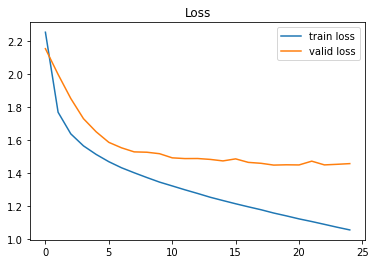

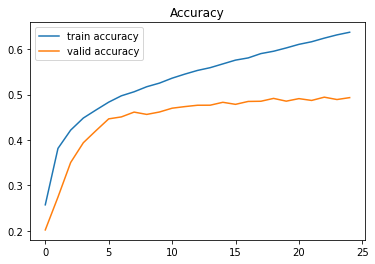

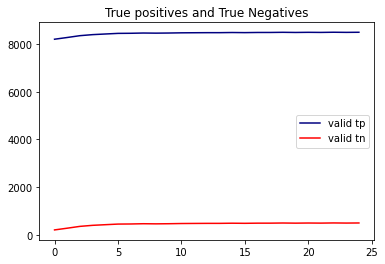

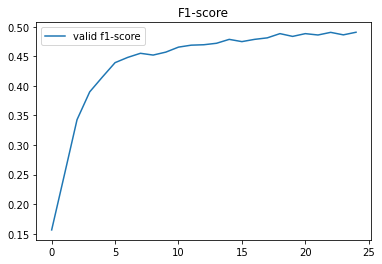

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(range(len(valid_tp)), valid_tp, label="valid tp", color="navy")
plt.plot(range(len(valid_tn)), valid_tn, label="valid tn", color="red")
plt.legend()
plt.title("True positives and True Negatives")
plt.show()


plt.plot(range(len(valid_f1sc)), valid_f1sc, label="valid f1-score")
plt.legend()
plt.title("F1-score")
plt.show()